In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks,Input
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model

from utils.data_utils import get_data_loader  # Assuming this is a custom utility
from utils.viz_utils import plot_training_history, plot_confusion_matrix

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
INPUT_SHAPE = (256, 256)
INPUT_SHAPE_MODEL = (256, 256, 3)
BATCH_SIZE = 32
NUM_CLASSES =7

In [13]:
def evaluate_and_plot_confusion_matrix(model, test_loader, model_name="efficientnetb5_v1"):
    """
    Evaluates the model on the test_loader (Keras ImageDataGenerator) and plots the confusion matrix.
    Compatible with get_data_loader() returning a Keras DirectoryIterator.
    """
    print("\nGenerating detailed classification report...")

    # Get class names from the generator
    if hasattr(test_loader, "class_indices"):
        # class_indices is a dict mapping class name to index
        class_names = list(test_loader.class_indices.keys())
    else:
        raise AttributeError("Could not infer class names from test_loader (expected attribute 'class_indices').")
    print("Inferred class names:", class_names)

    y_true = []
    y_pred = []

    # Number of steps = ceil(num_samples / batch_size)
    steps = int(np.ceil(test_loader.samples / test_loader.batch_size))

    for i in range(steps):
        batch = next(test_loader)
        batch_images, batch_labels = batch

        # Ensure images are float32 (should already be, but for safety)
        batch_images = tf.cast(batch_images, tf.float32)

        # Model prediction
        predictions = model.predict(batch_images, batch_size=batch_images.shape[0], verbose=0)

        # If class_mode="categorical", labels are one-hot
        if batch_labels.ndim > 1 and batch_labels.shape[1] > 1:
            y_true_batch = np.argmax(batch_labels, axis=1)
        else:
            y_true_batch = batch_labels.astype(int).flatten()

        y_pred_batch = np.argmax(predictions, axis=1)

        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)

        if (i + 1) % 10 == 0 or (i + 1) == steps:
            print(f"Processed batch {i+1}/{steps}")

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("\n✅ Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Remove unsupported arguments for plot_confusion_matrix
    plot_confusion_matrix(
        y_true,
        y_pred,
        class_names=class_names
    )

In [11]:
# --- Define data directory ---
data_dir = "data/Teeth_Dataset"

# --- Get augmented train loader ---
train_loader = get_data_loader(
    data_dir=data_dir,
    batch_size=BATCH_SIZE,
    image_size=INPUT_SHAPE,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    split="Training",
    augment=True
)

# --- Validation loader ---
val_loader = get_data_loader(
    data_dir=data_dir,
    batch_size=BATCH_SIZE,
    image_size=INPUT_SHAPE,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    split="Validation",
    augment=False
)

# --- Test loader ---
test_loader = get_data_loader(
    data_dir=data_dir,
    batch_size=16,
    image_size=INPUT_SHAPE,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    split="Testing",
    augment=False
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [5]:
images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Number of classes:", NUM_CLASSES)


Images shape: (32, 256, 256, 3)
Labels shape: (32, 7)
Number of classes: 7


# **START SIMPLE MODEL**

In [6]:


# --- Define model ---
model_0 = models.Sequential([
# First Conv Block
layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                    input_shape=INPUT_SHAPE_MODEL, kernel_initializer='he_normal'),
layers.BatchNormalization(),
layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                    kernel_initializer='he_normal'),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

# Second Conv Block
layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                    kernel_initializer='he_normal'),
layers.BatchNormalization(),
layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                    kernel_initializer='he_normal'),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

# Third Conv Block
layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                    kernel_initializer='he_normal'),
layers.BatchNormalization(),
layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                    kernel_initializer='he_normal'),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

# Fourth Conv Block
layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                    kernel_initializer='he_normal'),
layers.BatchNormalization(),
layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                    kernel_initializer='he_normal'),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.GlobalAveragePooling2D(),

# Dense layers
layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
layers.BatchNormalization(),
layers.Dropout(0.5),
layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
layers.BatchNormalization(),
layers.Dropout(0.5),
layers.Dense(NUM_CLASSES, activation='softmax')
])

model_0.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

In [7]:

def create_tensorboard_callback(base_dir, experiment_name):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(base_dir, experiment_name, timestamp)
    print(f"[INFO] Saving TensorBoard logs to: {log_dir}")
    return TensorBoard(log_dir=log_dir)

In [8]:

# --- Compile model ---
model_0.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='models/best_model_0_teeth_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    create_tensorboard_callback(
        base_dir="logs",
        experiment_name="teeth_model_baseline_from_scratch"
    )
]

history_model_0 = model_0.fit(
    train_loader,
    steps_per_epoch=len(train_loader),
    validation_data=val_loader,
    validation_steps=len(val_loader),
    epochs=100,
    callbacks=callbacks_list,
    verbose=1
)


[INFO] Saving TensorBoard logs to: logs\teeth_model_baseline_from_scratch\20250710-032904
Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 2.6051 - accuracy: 0.2216 - precision: 0.2737 - recall: 0.1318
Epoch 1: val_accuracy improved from -inf to 0.14494, saving model to models\best_model_0_teeth_model.h5
97/97 [==============================] - 86s 784ms/step - loss: 2.6051 - accuracy: 0.2216 - precision: 0.2737 - recall: 0.1318 - val_loss: 4.3250 - val_accuracy: 0.1449 - val_precision: 0.1493 - val_recall: 0.1449 - lr: 0.0010
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 2.1506 - accuracy: 0.2611 - precision: 0.3391 - recall: 0.1338
Epoch 2: val_accuracy improved from 0.14494 to 0.25681, saving model to models\best_model_0_teeth_model.h5
97/97 [==============================] - 42s 430ms/step - loss: 2.1506 - accuracy: 0.2611 - precision: 0.3391 - recall: 0.1338 - val_loss: 2.6844 - val_accuracy: 0.2568 - val_precision: 0.2822 - val_recall: 0

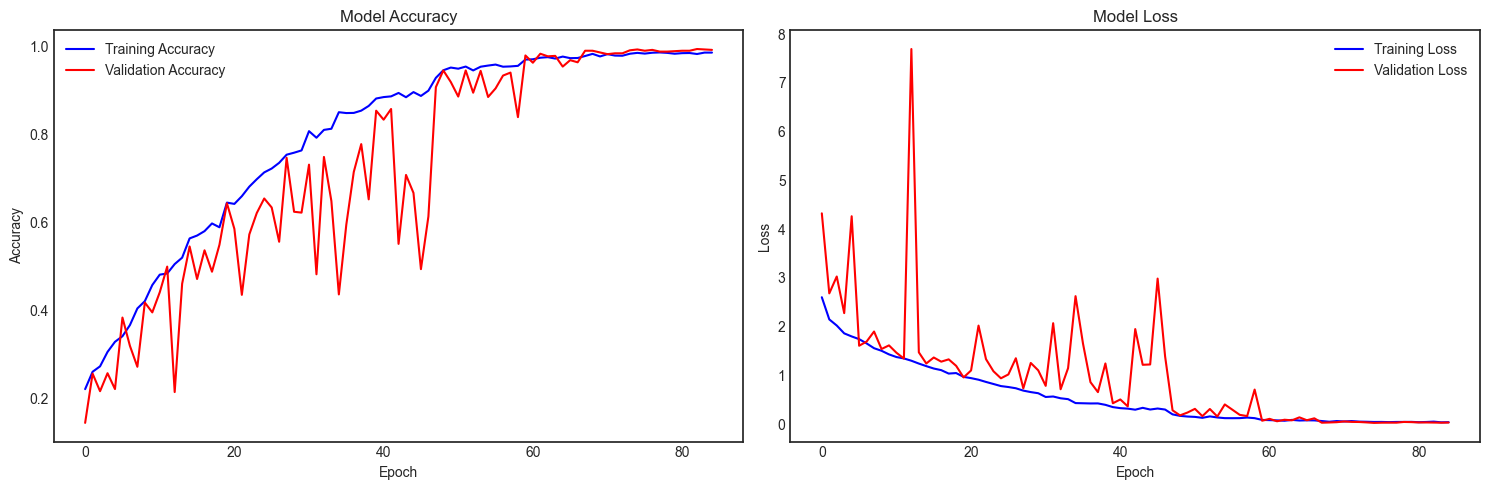

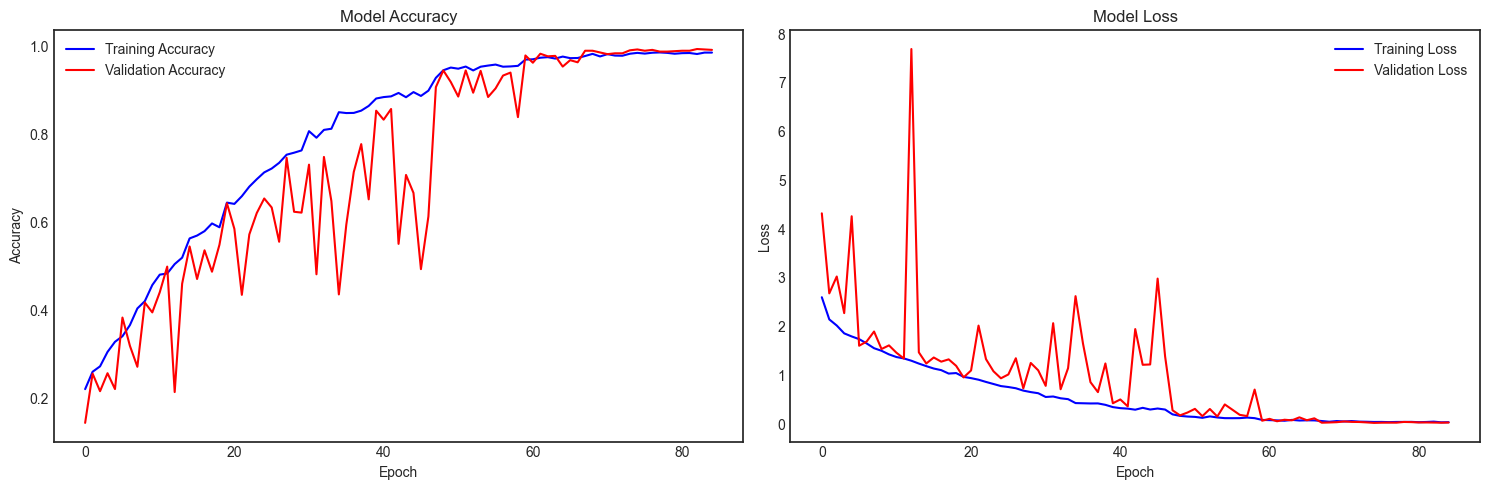

In [9]:
plot_training_history(history_model_0,"teeth_model_0_baseline_from_scratch")


Generating detailed classification report...
Inferred class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Processed batch 10/65
Processed batch 20/65
Processed batch 30/65
Processed batch 40/65
Processed batch 50/65
Processed batch 60/65
Processed batch 65/65

✅ Classification Report:

              precision    recall  f1-score   support

         CaS       0.98      1.00      0.99       160
         CoS       1.00      0.99      1.00       149
         Gum       0.98      0.98      0.98       120
          MC       0.96      0.97      0.96       180
          OC       0.95      0.95      0.95       108
         OLP       0.98      0.97      0.97       180
          OT       1.00      0.98      0.99       131

    accuracy                           0.98      1028
   macro avg       0.98      0.98      0.98      1028
weighted avg       0.98      0.98      0.98      1028



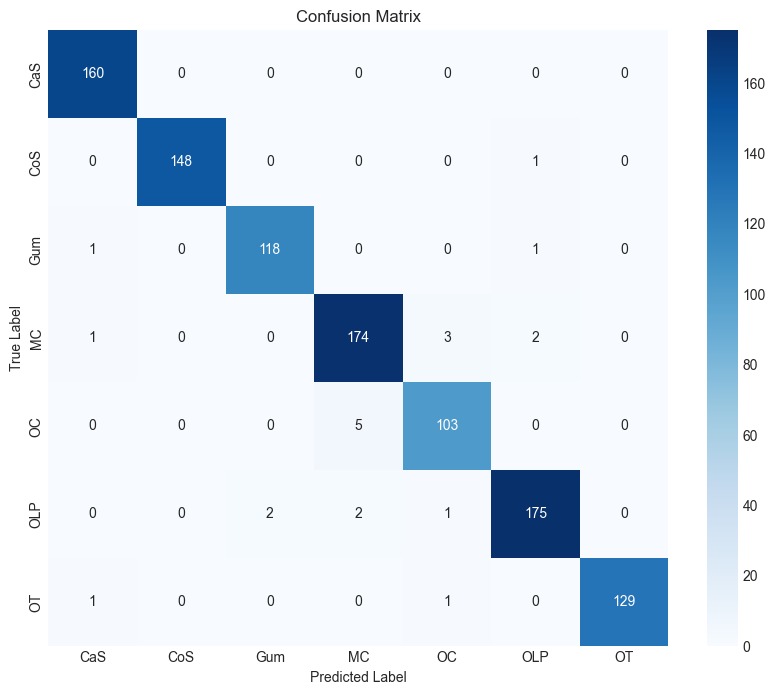

In [14]:
evaluate_and_plot_confusion_matrix(model_0, test_loader, model_name="teeth_model_baseline_from_scratch")

In [15]:
model_0.save('models/final_model_0_teeth_model_baseline_from_scratch.h5')
print("\nModel saved as 'model_0_teeth_model.h5'")


Model saved as 'model_0_teeth_model.h5'


In [16]:

# Input
inputs = Input(shape=INPUT_SHAPE_MODEL)

# --- First Conv Block ---
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

# --- Second Conv Block ---
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

# --- Third Conv Block ---
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

# --- Fourth Conv Block ---
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

# --- Global Poolings ---
gap = layers.GlobalAveragePooling2D()(x)
gmp = layers.GlobalMaxPooling2D()(x)

# --- Concatenate ---
concat = layers.Concatenate()([gap, gmp])

# --- Dense layers ---
x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(concat)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# --- Model ---
model_1 = Model(inputs=inputs, outputs=outputs)

model_1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 256, 256, 32  128        ['conv2d_8[0][0]']               
 rmalization)                   )                                                             

In [17]:

# --- Compile model ---
model_1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

callbacks_list_model_1 = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='models/best_model_1_teeth_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    create_tensorboard_callback(
        base_dir="logs",
        experiment_name="teeth_model_baseline_model_1_from_scratch"
    )
]



[INFO] Saving TensorBoard logs to: logs\teeth_model_baseline_model_1_from_scratch\20250710-041547
